## Predicción del PH de Planta de Tratameinto de Agua Potable Achachicala

### Introducción

El objetivo del presente trabajo es desarrollar un modelo que permita predecir la nivel de PH de la planta de tratamiento de agua Achichicala. Esto a partir de los datos tomados diariamente en un lapso de 6 meses.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from datetime import datetime
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

### Datos

Los datos provienenen de las mediciones del nivel de PH de tomados de la planta Achachicala, ubicada en la ciudad de La Paz en Bolivia, como parte del control normado por Ley. El rango de tiempo es de 6 meses, con una frecuencia de una muestra por día. La muestra se tomó entre el primero de enero y el 30 de junio del 2021.

In [4]:
data_path = os.path.join(os.getcwd(), '../data/ph_Achachicala.xlsx')
df = pd.read_excel(data_path)
df.head(2)

,Date,Ph
0,2021-01-01,9.50
1,2021-01-02,9.14


### Exploración inicial de Datos

El primer paso es realizar una exploración inicial de los datos.

In [5]:
print(df.dtypes.to_frame().T)
df_1 = df.set_index('Date')

             Date       Ph
0  datetime64[ns]  float64


Revisando por valores faltantes.

In [6]:
print(df_1.isna().sum())
print(df_1.isnull().sum(), '\n')
print(df_1[df_1['Ph']==0])

Ph    0
dtype: int64
Ph    0
dtype: int64 

Empty DataFrame
Columns: [Ph]
Index: []


Revisando valores Repetidos

In [7]:
print('número de índices ',len(df_1.index.unique()))
our_date_range = df_1.index.max() - df_1.index.min()
print('número de días ', our_date_range)

número de índices  181
número de días  180 days 00:00:00


La diferencia se debe a la forma en que our_data_range fue calculado. En realidad no hay datos faltantes. Esto se puede comprobar de la siguiente manera:

In [8]:
new_index = pd.date_range(df_1.index.min(), df_1.index.max())
df_new = df_1.reindex(new_index, fill_value=0)
print(df_new[df_new['Ph']==0])

Empty DataFrame
Columns: [Ph]
Index: []


El siguiente paso es graficar la variable para explorar visualmente las propiedades de la serie.

<AxesSubplot: title={'center': 'PH Planta Achachicala'}>

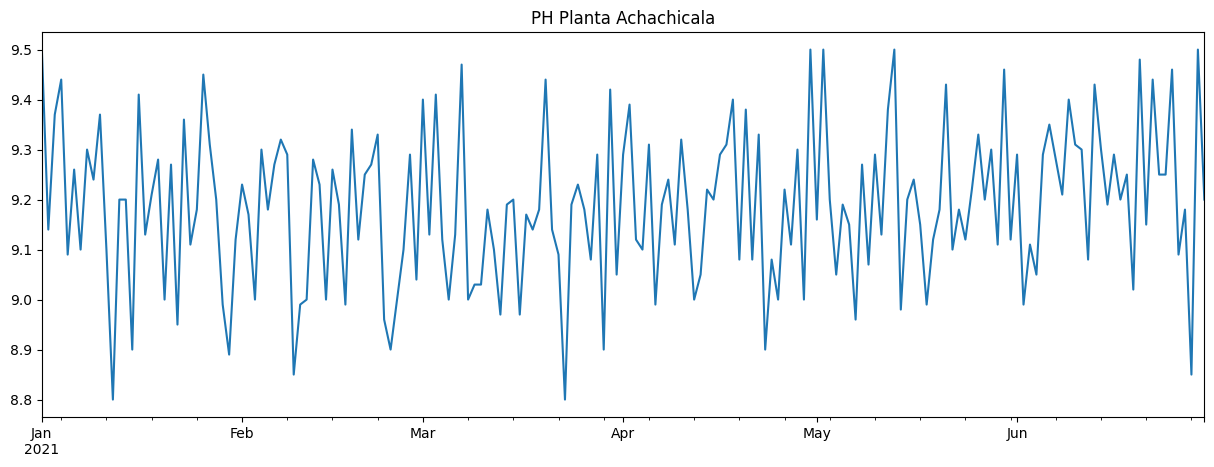

In [9]:
#quick plot of full time series
plt.figure(figsize = (15,5))
df_new['Ph'].plot(title='PH Planta Achachicala')

También se grafica un gráfico de violín, en intervalos semanales, para ver estudiar el promedio y la variaza en los 6 meses.

Text(0.5, 1.0, 'Variación Semanal de los Niveles de PH en la Planta de Tratamiento de Achichicala')

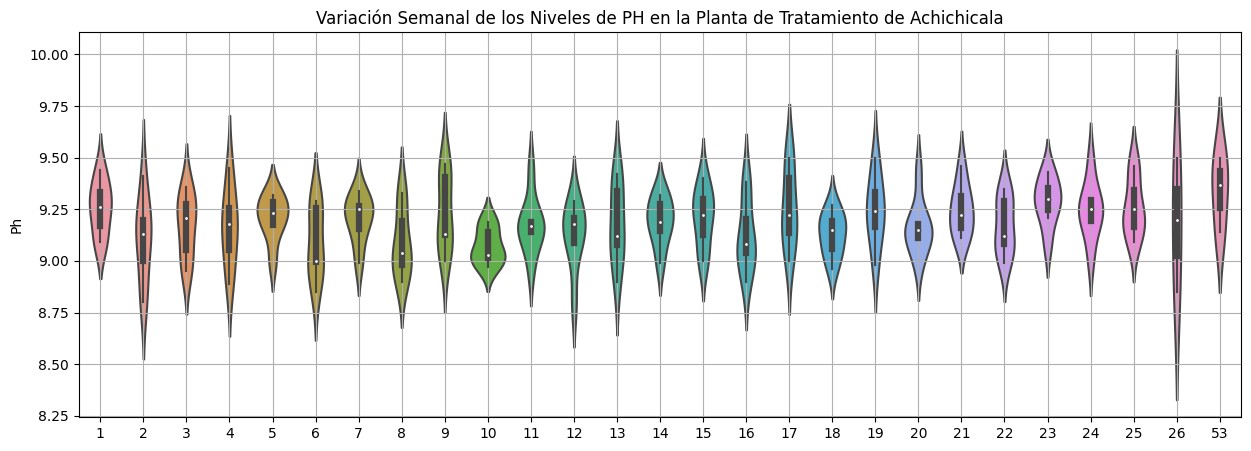

In [10]:
# violinplot of months to determine variance and range
plt.figure(figsize = (15,5))
sns.violinplot(x=df_new.index.week, y=df_new.Ph)
plt.grid(b=True)
plt.title("Variación Semanal de los Niveles de PH en la Planta de Tratamiento de Achichicala")

Visualmente, no hay *trend* (tendencia) ni *seasonality* (variaciones estacionarias).

Los modelos que se van a utilizar más adelante requieren que la serie sea estacionaria. Por lo tanto, es necesario comprobar si esta es una serie estacionaria. Para ello se debe cumplir que:
- Promedio constante
- Varianza constante (Homoscedasticity)
- Autocorrelación constante 
- No *seasonality* (variaciones estacionales)

Para corroborar si el promedio es constante se puede graficar un histograma. Si el promedio es constante, se debería visualizar una curva de campana. Esto debido a que visto de perfil, se tiene unicamente variaciones aleatoria (errores).

Text(0.5, 1.0, 'Frecuencia de la Serie')

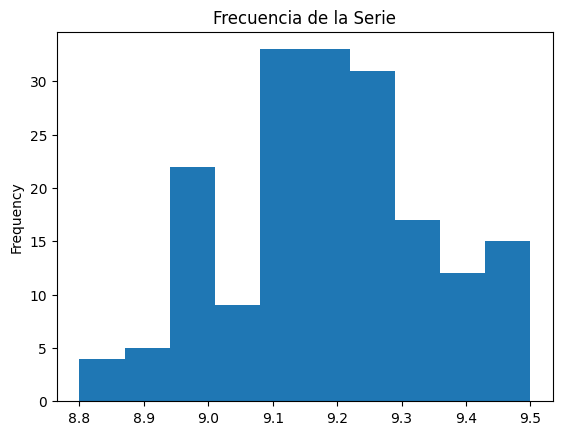

In [34]:
df_new.Ph.plot.hist()
plt.title("Frecuencia de la Serie")

Aproximadamente, se tiene una curva de campana. Por lo tanto se concluye que el promedio de la serie en el rango especificado es constante. 

Para comprobar si la autocorrelación sea constante, es necesario utilizar el test de Dickey-Fuller y ver el *P-value* resultante.

In [12]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df_new)
print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -7.912719371390771
p-value: 3.908958003929843e-12


La hipótesis *Null* es que nuestros datos No son estacionarios. Con un *P-value* de 3.908e-12, se tiene suficiente evidencia para rechazar la hipóteis *Null* y establecer nuestros datos como estacionarios. 

Como nota sobre el test de Dickey-Fuller. este es mucho más sensible a las variaciones en la autocorrelación que a las variaciones en la varianza. Por eso es importante visualizar la serie para corroborar los resultados del test.

Dado que nuestra serie es estacionaria, no es necesario hacer transformaciones en la misma.

### Predicción

#### ARMA

En este caso, al no haber tendencia, ni *seasonality* (variaciones estacionales), el modelo más adecuado es ARMA. 

Para construir el modelo es necesario identificar los valores de p y q. Para ello se utilizan los gráficos de autocorrelación  (autocorrelation function) y autocorrelación parcial (partial autocorrelation function).

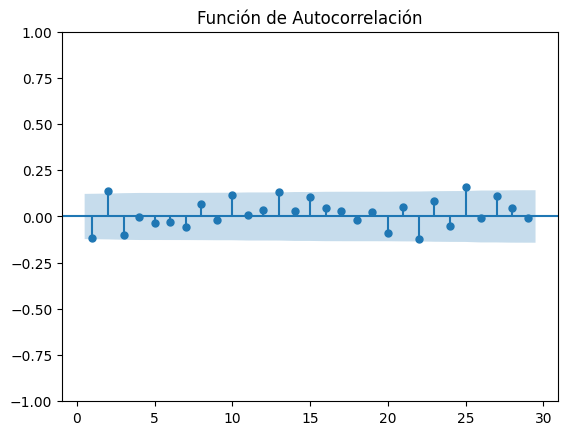

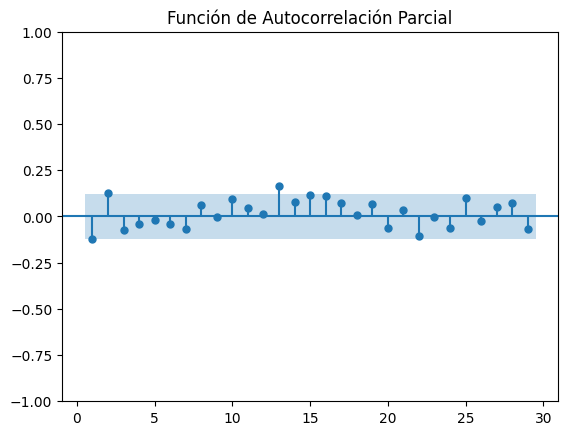

In [37]:
import statsmodels.api as sm
fig = sm.tsa.graphics.plot_acf(df_new.Ph, lags=range(1,30), alpha=0.1,title =  'Función de Autocorrelación')
fig = sm.tsa.graphics.plot_pacf(df_new.Ph, lags=range(1,30), alpha=0.1,title =  'Función de Autocorrelación Parcial')

De los anteriores gráficos se puede observar que p=2 (PACF muestra solo dos valores significativos) y q=2 (ACF muestra solo dos valores significativos). Con ello, se puede construir el modelo ARMA para predicir valores futuros.

Si bien se  usa la funcion ARIMA, haciendo d=0 se tiene el modelo ARMA.

In [14]:
import statsmodels.api as sm

model = sm.tsa.ARIMA(df_new[['Ph']], order=(2, 0, 2),trend='c')
arma = model.fit()

params = arma.params
print(params)


const     9.186835
ar.L1    -1.150626
ar.L2    -0.701474
ma.L1     1.068954
ma.L2     0.734240
sigma2    0.023326
dtype: float64


Visualizando la capacidad de predicción del modelo:

<AxesSubplot: title={'center': 'PH de la Planta Achachica: Predicciones modelo ARMA'}>

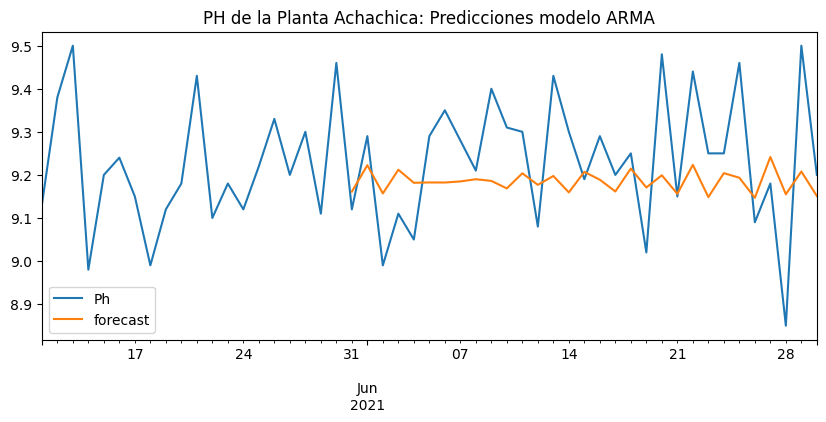

In [40]:
# plot predictions
pd.plotting.register_matplotlib_converters()
#use model.predict() start and end in relation to series
df_new['forecast'] = arma.predict(start = 150, end= 180)  
df_new[130:][['Ph', 'forecast']].plot(title='PH de la Planta Achachica: Predicciones modelo ARMA',figsize=(10, 4))

Se puede ver que la predicción captura la tendencia de los datos.

#### Deep Learning

Es posible mejorar este resultado utilizando un  modelo de Deep Learning. Se probará con dos, el algoritmo RNN (Recurrent Neural Network) y el algoritmo LSTM (Long-Short term memory). Parte del código utilizado fue extraído del material del curso: Specialized Models: Time Series and Survival Analysis, ofrecido por IBM Skills Network.

Primero se definen unas funciones utilitarias.

In [16]:
def get_n_last_days(df, series_name, n_days):
    """
    Extract last n_days of an hourly time series
    """
    
    return df[series_name][-(24*n_days):] 

def plot_n_last_days(df, series_name, n_days):
    """
    Plot last n_days of an hourly time series 
    """
    plt.figure(figsize = (10,5))   
    plt.plot(get_n_last_days(df, series_name, n_days), 'k-')
    plt.title('{0} Air Quality Time Series - {1} days'
              .format(series_name, n_days))
    plt.xlabel('Recorded Hour')
    plt.ylabel('Reading')
    plt.grid(alpha=0.3)

In [17]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, series_name, series_days, input_hours, 
                        test_hours, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_hours (int): length of sequence input to network 
    test_hours (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    
    forecast_series = get_n_last_days(df, series_name, series_days).values # reducing our forecast series to last n days

    train = forecast_series[:-test_hours] # training data is remaining days until amount of test_hours
    test = forecast_series[-test_hours:] # test data is the remaining test_hours

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_hours, sample_gap): 
        train_X.append(train[i:i+input_hours]) # each training sample is of length input hours
        train_y.append(train[i+input_hours]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_hours] 
    test_y = test[input_hours:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

Ahora se divide en training y test sets. En este caso se esta lidiando con series de tiempo que van a ser el input del algoritmo RNN. Por lo tanto es necesario definir el tamaño de los inputs del algoritmo y también la forma en que se van a dividir la serie. En nuestro caso, la función get_train_test_data se encarga de este preprocesado.

In [18]:
series_days = 56
input_hours = 12
test_hours = 24 # Hours left for testing.
# Test, use input_hours for input and the remaining as output
train_X, test_X_init, train_y, test_y = (get_train_test_data(df_new[['Ph']], 'Ph', series_days, 
                         input_hours, test_hours))

In [19]:
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (49, 12, 1)
Training output shape: (49,)
Test input shape: (12,)
Test output shape: (12,)


Es momento de entrenar la red neuronal. Primero se intentará con una red neuronal RNN sencilla, que sirva como referencia.

In [20]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """

    # initialize model
    model = Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

In [21]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_hours)  #predict range is going to be from end of X_init to length of test_hours
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

1/1 [==============================] - 0s 45ms/step


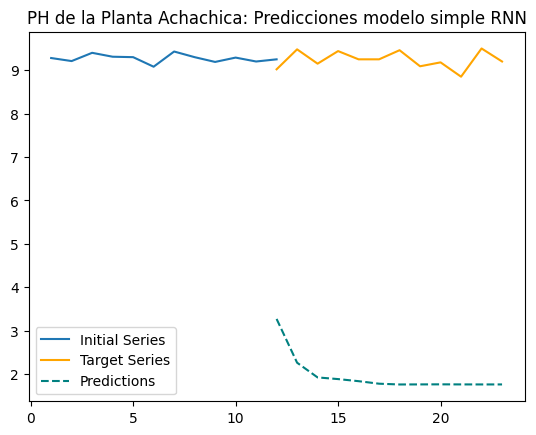

In [41]:
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)
predict_and_plot(test_X_init, test_y, model,
                 'PH de la Planta Achachica: Predicciones modelo simple RNN')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                120       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


Se puede observar que sus predicciones no se acercan a la realidad. Por ello, se probará con un segundo modelo, con mayor complejidad. se lo denominará model_2.

1/1 [==============================] - 0s 107ms/step


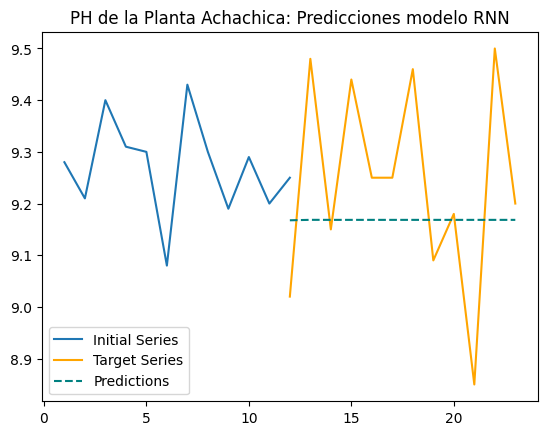

In [42]:
series_days = 56
input_hours = 12
test_hours = 24 

train_X, test_X_init, train_y, test_y = (get_train_test_data(df_new[['Ph']], 'Ph', series_days, 
                         input_hours, test_hours))

model_2 = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=1200)
predict_and_plot(test_X_init, test_y, model_2,
                 'PH de la Planta Achachica: Predicciones modelo RNN')

In [25]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 30)                960       
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 991
Trainable params: 991
Non-trainable params: 0
_________________________________________________________________


El resultado mejoró. 

Ahora se probará con el algorimto LSTM.

In [26]:
def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1))) #,return_sequences= True))
    #model.add(LSTM(cell_units_l2, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

1/1 [==============================] - 0s 37ms/step


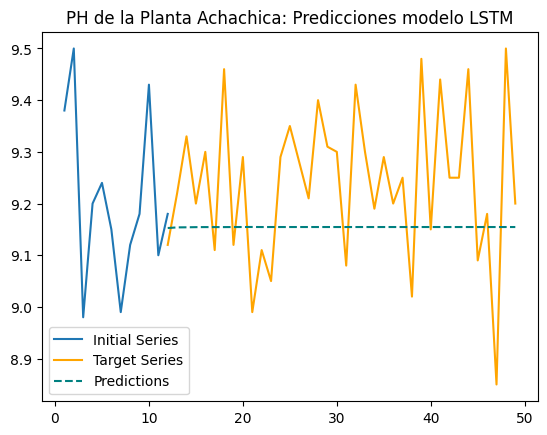

In [43]:
series_days = 100 
input_hours = 12
test_hours = 50

train_X, test_X_init, train_y, test_y = (get_train_test_data(df_new[['Ph']], 'Ph', series_days, 
                         input_hours, test_hours))

model_3 = fit_LSTM(train_X, train_y, cell_units=70, epochs=3000) 

predict_and_plot(test_X_init, test_y, model_3, 
                 'PH de la Planta Achachica: Predicciones modelo LSTM')

In [28]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 70)                20160     
                                                                 
 dense_2 (Dense)             (None, 1)                 71        
                                                                 
Total params: 20,231
Trainable params: 20,231
Non-trainable params: 0
_________________________________________________________________


No parece haber una mejora significativa entre el modelo 2 y el modelo 3, a pesar de la elevada complejidad de este último. Por este motivo, se prefiere usar el modelo 2. Este es un algoritmo RNN con 30 neuronas.

### Conclusiones

A pesar de la complejidad de los algoritmos de Deep Learning utilizados, RNN y LSTM, no se observa una mejora significativa respecto al modelo más simple de ARMA. Por lo tanto, se prefiere tomar este último como el modelo para realizar las predicciones. 